### Importing all the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Loading the dataset

In [2]:
df = pd.read_excel("premiums_young.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [3]:
df.shape

(20096, 13)

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

Here, we see that the column names have spaces and underscores in between them,
so we need consistency in the naming

In [5]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [6]:
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Exploratory Data Analysis- Data Cleaning

#### 1) Checking For Null Values 

In [7]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

Since, we have very less records with null/na values, let's drop them

#### Drop NA Values

In [8]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

##### Drop Duplicate values is any

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Statistics for the Numerical features

In [10]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


Here, for the number_of_dependants feature, the min value is -3.00
It might have been that during data collection the positive values have been converted to negative values


In [11]:
#Records which have number of dependants < 0
df[df['number_of_dependants']<0]['number_of_dependants'].unique() #unique values in df where number_of_dependants < 0

array([-3, -1])

In [12]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

##### Plotting Boxplots for each of the numerical features to see if there are any outliers

In [13]:
###Numerical Columns
num_columns = df.select_dtypes(['float64','int64'])
num_columns.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [14]:
df[df['age']>72]['age'].unique()

array([], dtype=int64)

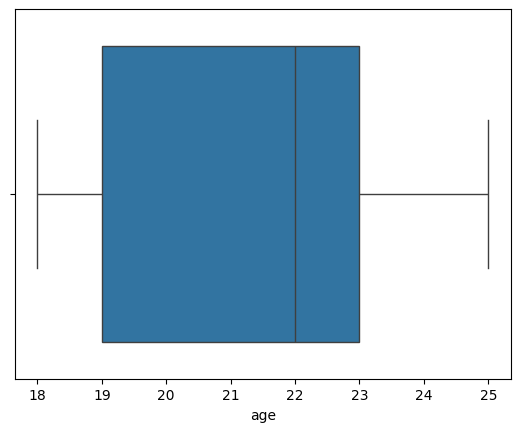

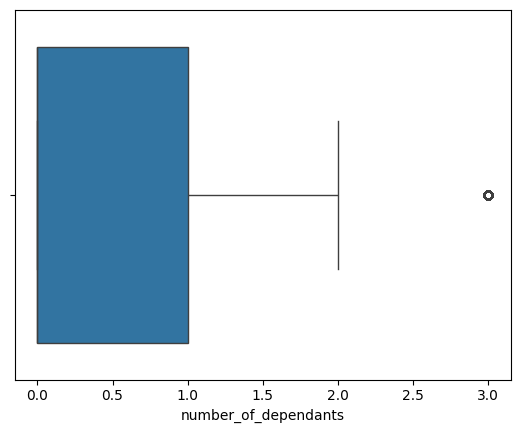

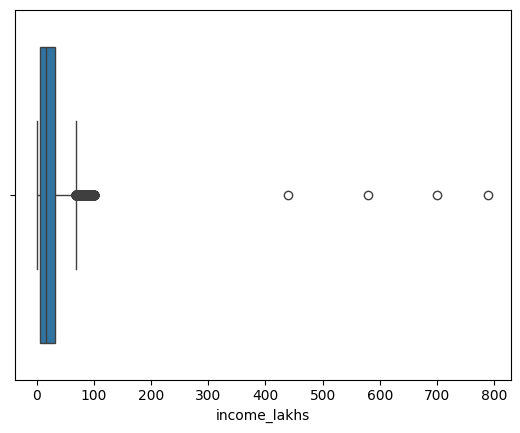

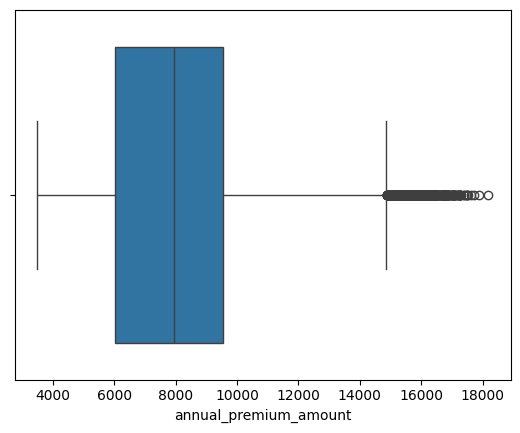

In [15]:
for col in num_columns.columns:
    sns.boxplot(x=df[col])
    plt.show()

In [16]:
## Removing Outliers for age column
#Let's set threshold age<=100, and remove all the records with age>100

#Unique ages which are > 100
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [17]:
df1 = df[df['age']<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

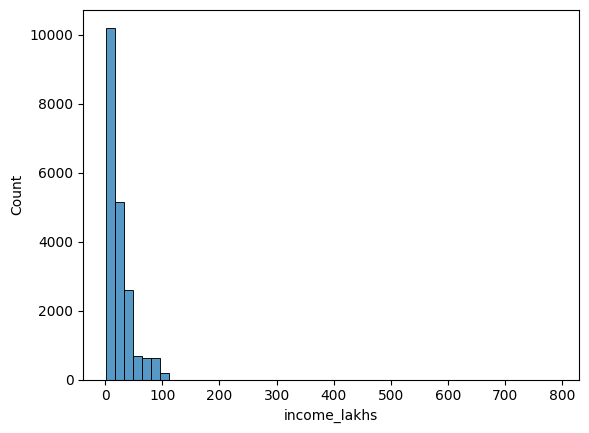

In [18]:
##income_lakhs column
sns.histplot(df1.income_lakhs,bins=50)

In [19]:
def get_iqr_bounds(col):
    Q1, Q3 = df[col].quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

endpoints = get_iqr_bounds('income_lakhs')
endpoints

(-31.5, 68.5)

In [20]:
df1[df1['income_lakhs']>100]['income_lakhs'].shape

(4,)

There are 10 records with income > 100 lakhs a year which is less, so we consider records that 
are < 100 lakhs a year

In [21]:
df2=df1[df1.income_lakhs<100].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20054.000000,20054.000000,20054.000000,20054.000000
mean,21.494016,0.722449,22.266530,8136.902413
std,2.294382,0.937033,21.526939,2748.132286
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6019.000000
50%,21.000000,0.000000,16.000000,7936.500000
75%,23.000000,1.000000,31.000000,9552.750000
max,25.000000,3.000000,99.000000,18186.000000


Since, there are very littile outliers in annual_premium_amount, we ignore them

### Visualising the numerical features using histogram to see the distribution(whether it is left skewed, right skewed or normal distribution)

### Univariate Analysis

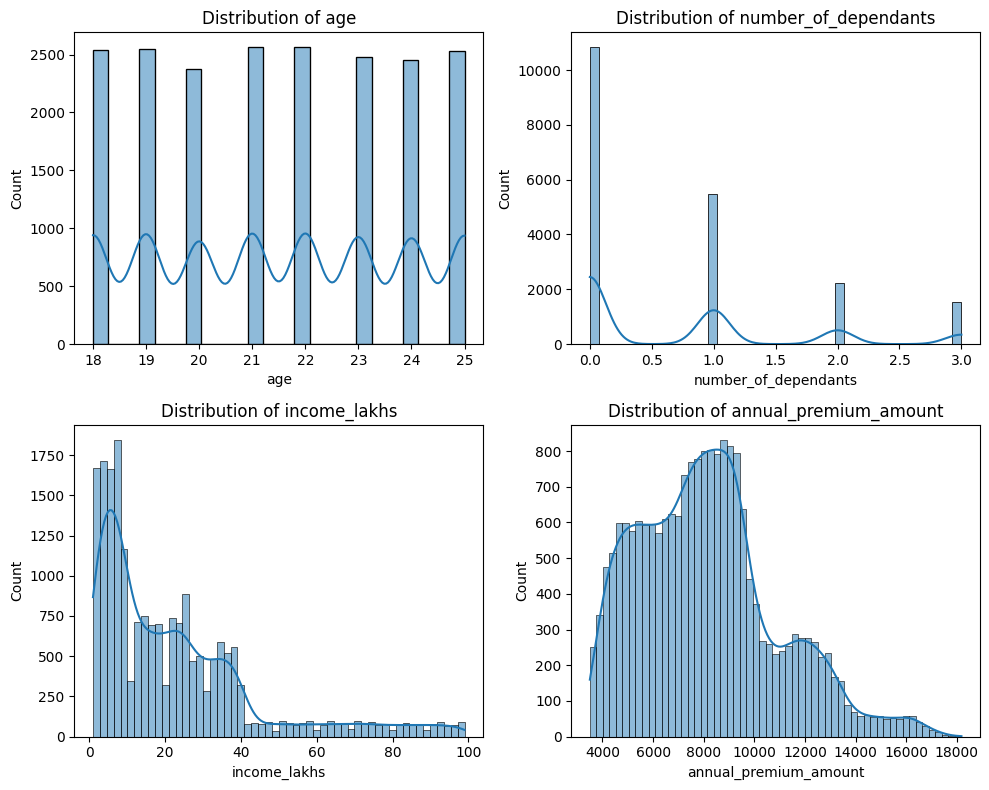

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `num_columns` is your list of numerical columns
#n_cols = 2  # Number of columns per row
#n_rows = (len(num_columns) + 1) // n_cols  # Calculate the required rows

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Flatten axes to make it easier to iterate (even if it's a 1D array)
#axes = axes.flatten()
for i, col in enumerate(num_columns):
    ax = axs[i//2, i%2] #Determine the position of the subplot in the grid
    sns.histplot(df2[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


<Axes: xlabel='age', ylabel='annual_premium_amount'>

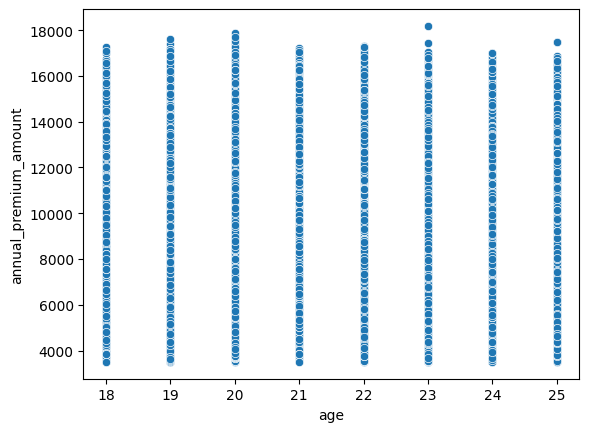

In [23]:
#Bivariate analysis
sns.scatterplot(df2, x='age',y='annual_premium_amount')

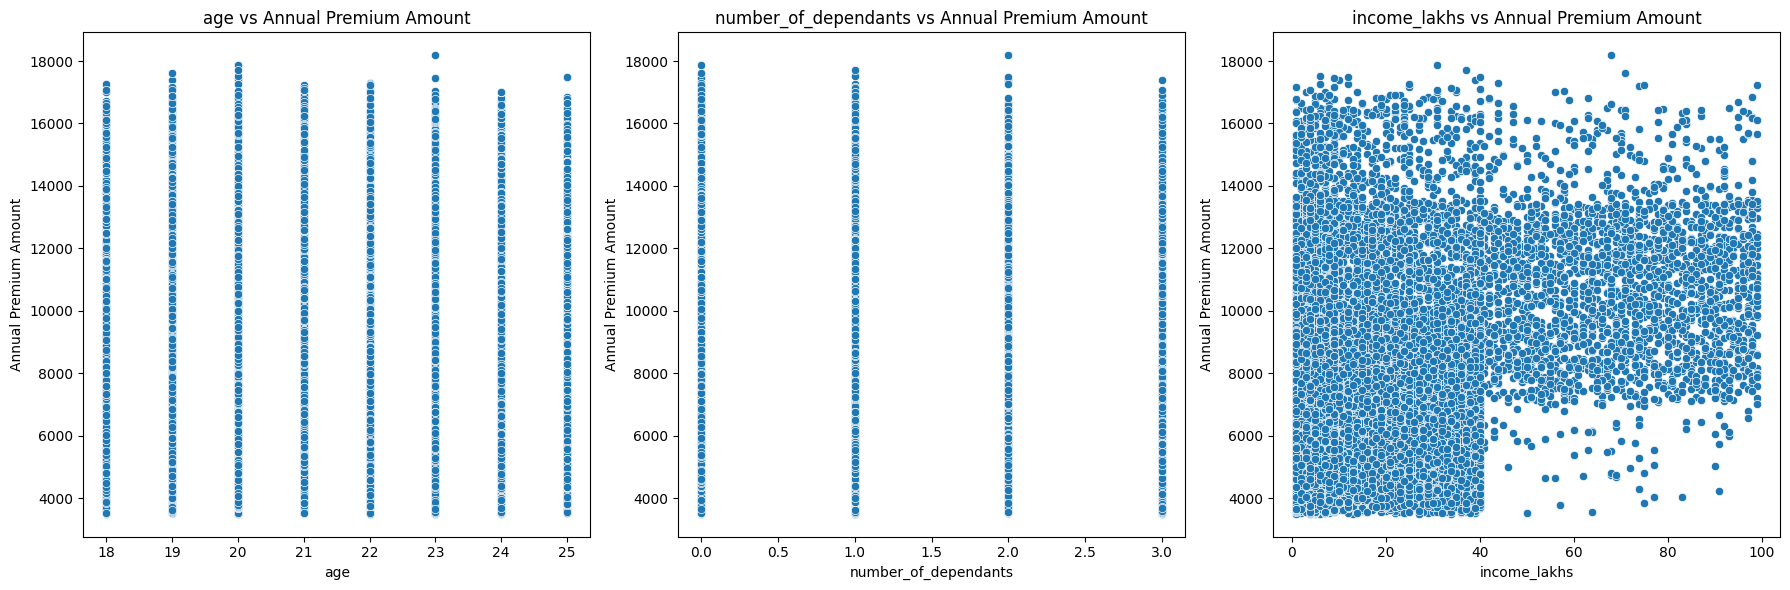

In [24]:
##Bivariate analysis of  age,number_of_dependants, income_lakhs with annual_premium_amount
numeric_features = ['age', 'number_of_dependants', 'income_lakhs']

fig, axes = plt.subplots(1,len(numeric_features),figsize=(18, 6))

for ax, column in zip(axes, numeric_features): #Zip combines the params and gives output as list of tuples
    sns.scatterplot(x=df2[column],y=df2['annual_premium_amount'],ax=ax)
    ax.set_title(f'{column} vs Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [25]:
##Categorical columns
categorical_df = df2.select_dtypes(['object'])
cat_col = categorical_df.columns

for col in cat_col:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


Here, we see that smoking_status column has no umiformity in the values it contains

In [26]:
df2['smoking_status'].replace({ 
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking' : 'No Smoking'
}, inplace=True)
df2['smoking_status'].unique()

C:\Users\punit\AppData\Local\Temp\ipykernel_8780\1740355420.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

<Axes: xlabel='gender'>

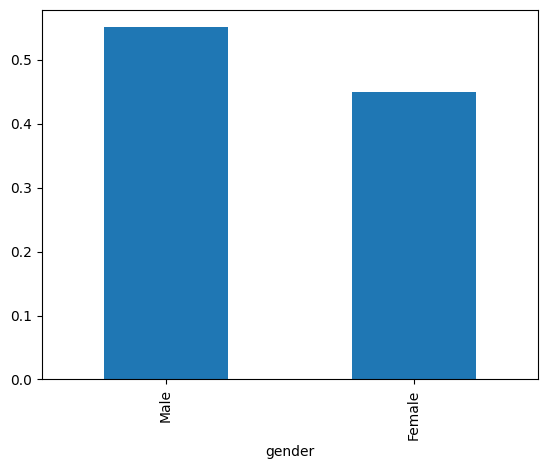

In [27]:
##Univariate Analysis on categorical columns
#Percentage Distribution

pct_count = df2['gender'].value_counts(normalize=True)
pct_count.plot(kind='bar')

C:\Users\punit\AppData\Local\Temp\ipykernel_8780\1201047432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\punit\AppData\Local\Temp\ipykernel_8780\1201047432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\punit\AppData\Local\Temp\ipykernel_8780\1201047432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\punit\AppData\Local\Temp\ipykernel_8780\1201047432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=

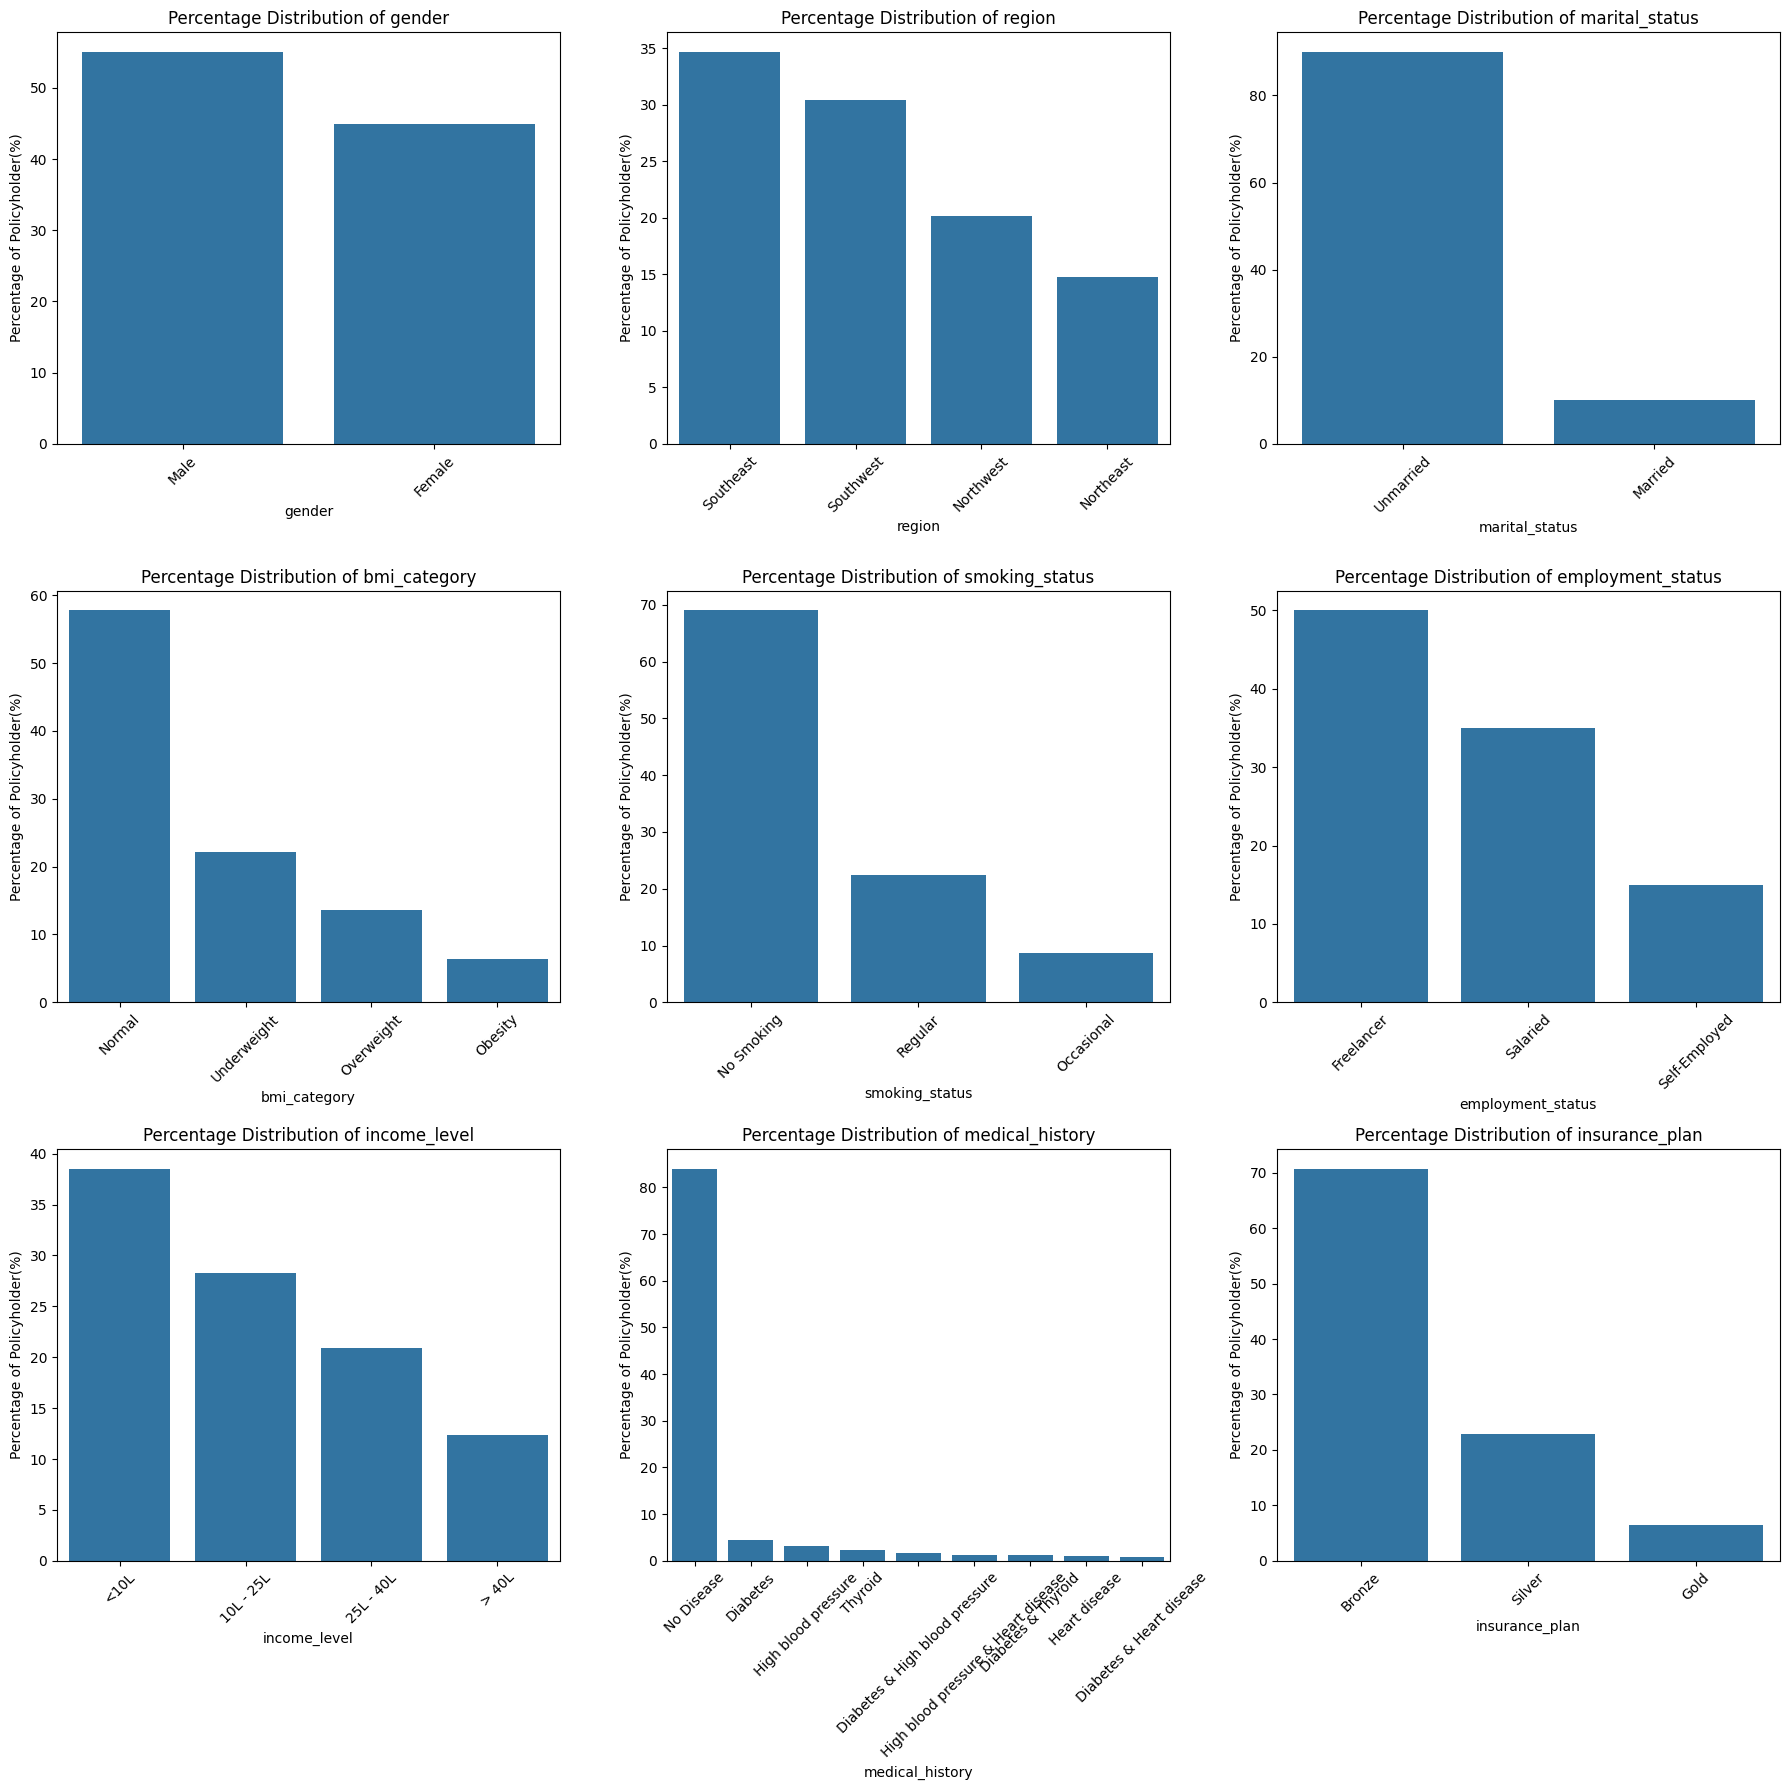

In [28]:
fig, axes = plt.subplots(3,3,figsize=(18, 18))
axes = axes.flatten()

for ax, column in zip(axes, cat_col): #Zip combines the params and gives output as list of tuples
    category_counts =df2[column].value_counts(normalize=True) * 100
    sns.barplot(x=category_counts.index, y=category_counts.values,ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Percentage of Policyholder(%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   362    1995


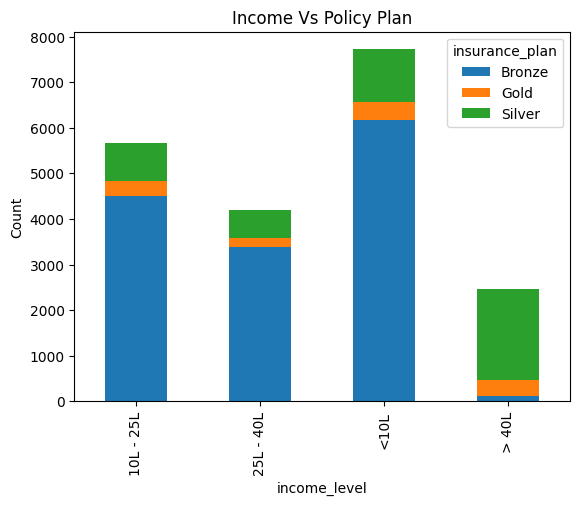

In [29]:
##Visualisation to see at different income levels the type of policies purchased
crosstab = pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar',stacked=True)
plt.title('Income Vs Policy Plan')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

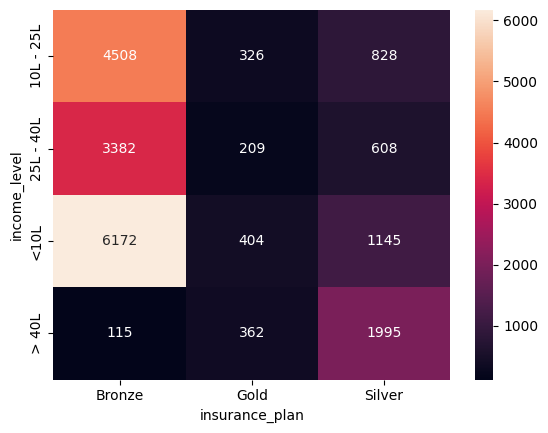

In [30]:
sns.heatmap(crosstab,annot=True,fmt='d')

### Feature Engineering

In [31]:
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [32]:
### We have been provided with the risk score associcated with each disease
risk_scores = {
    "diabetes" : 6,
    "heart disease" : 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

In [33]:
## So in cases of 'Diabetes & High blood pressure' we need to add the risk_scores of both diseases
df2['medical_history'].str.split('&')

0        [High blood pressure]
1                 [No Disease]
2                 [No Disease]
3                 [No Disease]
4                 [No Disease]
                 ...          
20091             [No Disease]
20092               [Diabetes]
20093             [No Disease]
20094             [No Disease]
20095             [No Disease]
Name: medical_history, Length: 20054, dtype: object

In [34]:
df2[['disease1','disease2']]=df2['medical_history'].str.split('&',expand=True).apply(lambda x:x.str.lower()) #Gives DataFrame with 2 cols(and convert them to lower
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None


In [35]:
# Fill null values with 'none' in 'disease1', 'disease2'
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

#Calculate the risk_score in disease1 and disease2 and add it up

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

#Calculate Normalised Risk Score
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

df2['normalised_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(20)

C:\Users\punit\AppData\Local\Temp\ipykernel_8780\2186209464.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none',inplace=True)
C:\Users\punit\AppData\Local\Temp\ipykernel_8780\2186209464.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalised_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6.0,0.75
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0.0,0.00
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0.0,0.00
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0.0,0.00
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0.0,0.00
5,22,Female,Southwest,Unmarried,0,Underweight,Regular,Freelancer,25L - 40L,30,High blood pressure,Gold,15473,high blood pressure,none,6.0,0.75
6,19,Male,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,<10L,8,No Disease,Bronze,4097,no disease,none,0.0,0.00
7,18,Female,Northwest,Unmarried,1,Underweight,No Smoking,Salaried,<10L,5,Diabetes & High blood pressure,Bronze,8187,diabetes,high blood pressure,NaN,NaN
8,23,Male,Northwest,Unmarried,0,Underweight,No Smoking,Salaried,<10L,8,No Disease,Bronze,5387,no disease,none,0.0,0.00
9,20,Female,Northeast,Unmarried,0,Normal,Occasional,Salaried,10L - 25L,18,No Disease,Bronze,8866,no disease,none,0.0,0.00


In [36]:
#Performing Label Encoding for Categorical Values
# 1)'insuranc_plan' column
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze' : 1, 'Silver':2, 'Gold': 3})
df2['insurance_plan'].unique()

array([2, 1, 3])

In [37]:
#2)'income_level' column
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L':2, '> 40L':3, '25L - 40L':4})
df2['income_level'].unique()

array([3, 1, 2, 4])

In [38]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalised_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,3,99,High blood pressure,2,13365,high blood pressure,none,6.0,0.75
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0.0,0.00
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,3,97,No Disease,2,11857,no disease,none,0.0,0.00
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0.0,0.00
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0.0,0.00


In [39]:
#One-hotencoding nominal columns
nom_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status']
df3 = pd.get_dummies(df2,columns=nom_cols,drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,High blood pressure,2,13365,high blood pressure,none,6.0,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0.0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,No Disease,2,11857,no disease,none,0.0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0.0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0.0,...,1,0,1,0,1,0,0,0,0,0


In [40]:
#Drop Columns that are not useful:
df4 = df3.drop(['medical_history', 'disease1', 'disease2','total_risk_score'],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,2,13365,0.75,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.00,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,2,11857,0.00,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.00,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.00,1,0,1,0,1,0,1,0,0,0,0,0


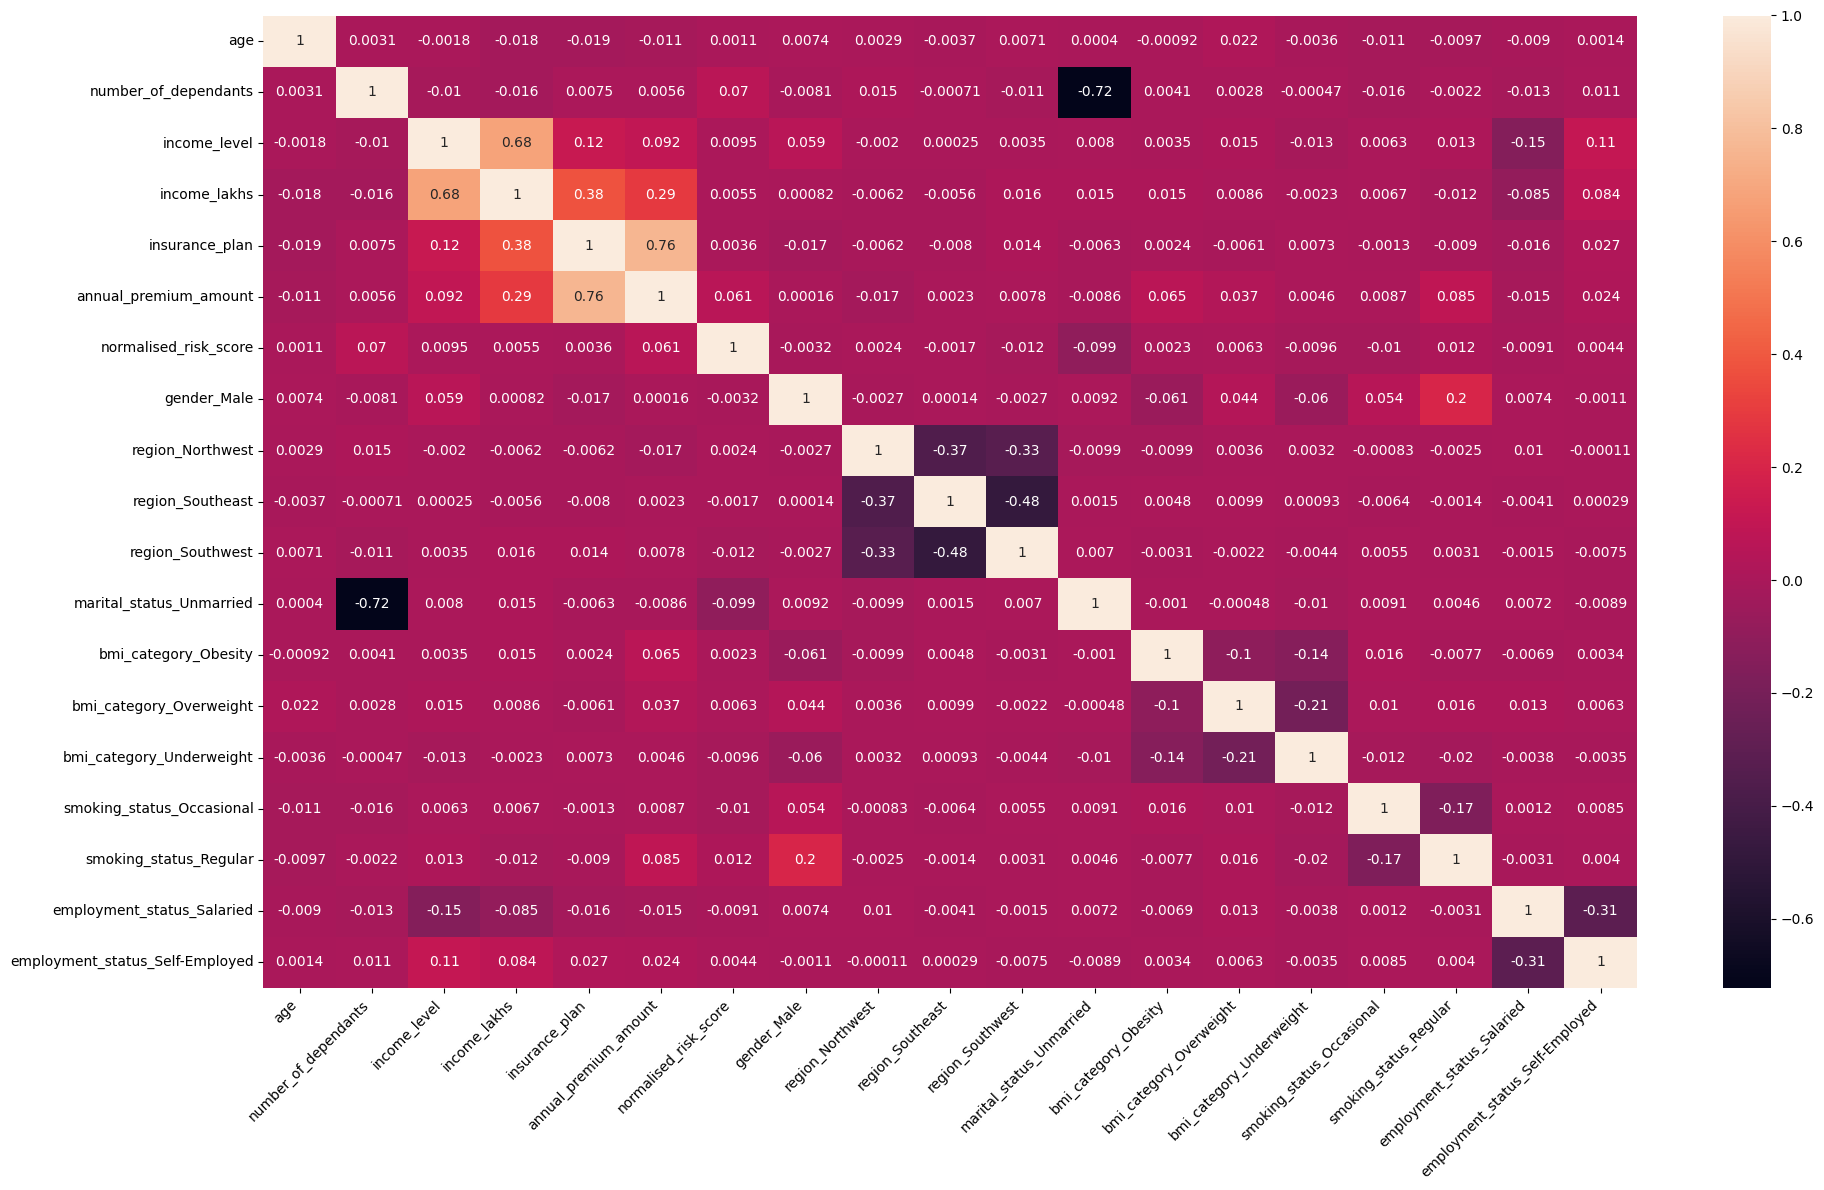

In [41]:
##Correlation Matrix
cm = df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,2,13365,0.75,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.00,0,1,0,0,1,0,0,1,0,0,0,0


In [43]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalised_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [44]:
## Features Selection Using VIF(Variance Inflation Factor) as it assess the correlation of each feature with all other features in the dataset
#1) Before that let's do scaling of features which is benficial later in calculating the VIF
from sklearn.preprocessing import MinMaxScaler

X= df4.drop("annual_premium_amount",axis=1) 
y= df4['annual_premium_amount'] #annual_premium_amount-->Target variable

cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
scaler= MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.666667,1.000000,0.5,0.75,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020408,0.5,0.00,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.666667,0.979592,0.5,0.00,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.142857,0.0,0.00,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.132653,0.0,0.00,1,0,1,0,1,0,1,0,0,0,0,0


In [45]:
X.fillna(0,inplace=True)
X.isnull().sum()

age                                0
number_of_dependants               0
income_level                       0
income_lakhs                       0
insurance_plan                     0
normalised_risk_score              0
gender_Male                        0
region_Northwest                   0
region_Southeast                   0
region_Southwest                   0
marital_status_Unmarried           0
bmi_category_Obesity               0
bmi_category_Overweight            0
bmi_category_Underweight           0
smoking_status_Occasional          0
smoking_status_Regular             0
employment_status_Salaried         0
employment_status_Self-Employed    0
dtype: int64

In [46]:
#calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Variable']= data.columns
    vif_df['VIF']= [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df    

In [47]:
calculate_vif(X)

,Variable,VIF
0,age,3.143557
1,number_of_dependants,1.867445
2,income_level,3.943026
3,income_lakhs,4.385254
4,insurance_plan,1.641892
5,normalised_risk_score,1.119832
6,gender_Male,2.316888
7,region_Northwest,2.148452
8,region_Southeast,2.971450
9,region_Southwest,2.731196


Columns with VIF < 10 is good, here we see that the columns have VIF<5
income_level and income_lakhs are more or less the same, so dropping income_level

In [48]:
X_reduced = X.drop('income_level',axis="columns")
X_reduced.head(5)

,age,number_of_dependants,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.5,0.75,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020408,0.5,0.00,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.979592,0.5,0.00,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.142857,0.0,0.00,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.132653,0.0,0.00,1,0,1,0,1,0,1,0,0,0,0,0


In [49]:
y.shape, X_reduced.shape, X.shape, df4.shape

((20054,), (20054, 17), (20054, 18), (20054, 19))

### Model Training

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)




x train:  (14037, 17)
x test:  (6017, 17)
y train:  (14037,)
y test:  (6017,)


In [51]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.599712463901497, 0.5900718822141033)

When the model is overfitting, the train_score > test_score

In [52]:
model_lr.coef_

array([ 7.41226236e+01, -1.09717609e+01, -2.27396365e+00,  7.00476600e+03,
        5.65050972e+02, -3.25555183e+01, -1.00973695e+02, -1.51479827e+00,
       -5.81429489e+01, -3.71881145e+01,  7.50138072e+02,  4.30181077e+02,
        9.91510124e+01,  3.04119971e+02,  6.59253311e+02, -2.90978516e+01,
        1.61059771e+01])

In [53]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
1710,0.714286,0.0,0.040816,0.0,0.0,0,0,1,0,1,0,1,0,0,0,0,0


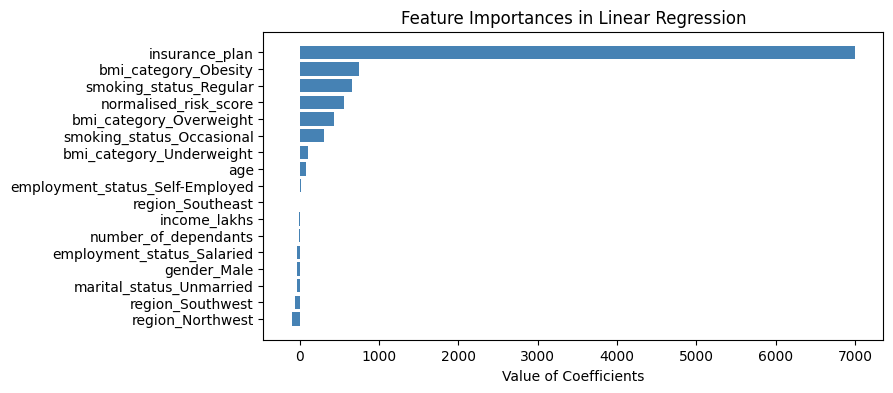

In [54]:
### how much each of these coeffs are contributing to the final prediction(usually in other models, feature_importances is used
feature_importances = model_lr.coef_ #for linear regression
coeff_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=['Coefficients'])
coeff_df = coeff_df.sort_values(by='Coefficients', ascending=True)

#Plotiing a horizontal barplot
plt.figure(figsize=(8,4))
plt.barh(coeff_df.index,coeff_df['Coefficients'],color='steelblue')
plt.title("Feature Importances in Linear Regression")
plt.xlabel('Value of Coefficients')
plt.show()

In [55]:
##Using Regularised models
model_rg = Ridge(alpha=10)
model_rg.fit(X_train,y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score


(0.5996686082053402, 0.5901211375771103)

Norhing significant change in the score 

In [56]:
##Using XGboost Regressor
from xgboost import XGBRegressor

model_xgbr = XGBRegressor()
model_xgbr.fit(X_train,y_train)
train_score = model_xgbr.score(X_train, y_train)
test_score = model_xgbr.score(X_test, y_test)
train_score, test_score

(0.720822811126709, 0.5508183836936951)

In [57]:
##Fine tuning the parameters using RandomisedSearchCV as the dataset is large 
param_grid = {
    'n_estimators' : [20,40,50],
    'learning_rate' : [0.01,0.1,0.2],
    'max_depth': [3,4,5],
}
random_search = RandomizedSearchCV(model_xgbr,param_grid,n_iter=10,cv=3,scoring='r2',random_state=10)
random_search.fit(X_train,y_train)
random_search.best_score_

np.float64(0.59695965051651)

In [58]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

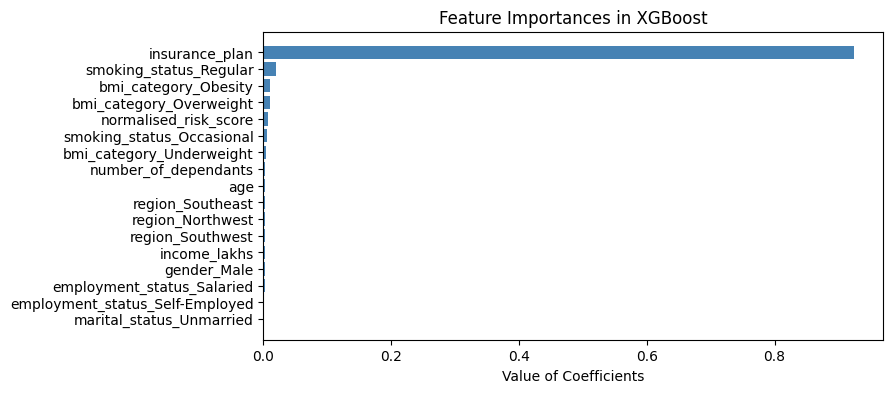

In [59]:
best_model = random_search.best_estimator_

feature_importances = best_model.feature_importances_

coeff_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=['Coefficients'])
coeff_df = coeff_df.sort_values(by='Coefficients', ascending=True)

#Plotiing a horizontal barplot
plt.figure(figsize=(8,4))
plt.barh(coeff_df.index,coeff_df['Coefficients'],color='steelblue')
plt.title("Feature Importances in XGBoost")
plt.xlabel('Value of Coefficients')
plt.show()

Since, XGBoost is a Tree based model, the feature_importances is not interpretable as in the case
of Linear Regression where the coeff's are used.

### Error Analysis


In [60]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals * 100/y_test

results_df = pd.DataFrame({
    'actual' : y_test,
    'predicted' : y_pred,
    'diff' : residuals,
    'diff_pct' : residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
1710,4096,7074.836426,2978.836426,72.725499
11963,4503,7074.836426,2571.836426,57.113845
8719,8332,10819.421875,2487.421875,29.853839
7208,11578,10101.258789,-1476.741211,-12.754718
9416,7045,6625.875977,-419.124023,-5.949241


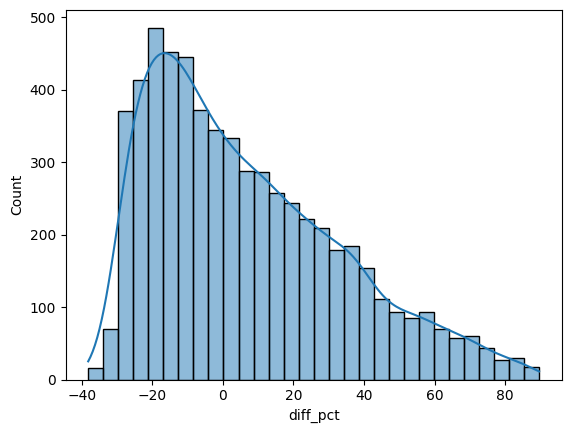

In [61]:
sns.histplot(results_df['diff_pct'],kde=True)
plt.show()

There are some records where we are predicting the insurance_premiumm to be 80% higher which is not acceptable

The busisness has set the error_threshold =10

In [62]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4418, 4)

In [63]:
extreme_results_df.shape[0] *100/ results_df.shape[0]

73.42529499750707

We have 39% customers for whom we will either overcharge or undercharge by 10% or more

In [64]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct',ascending=False)

,actual,predicted,diff,diff_pct
10165,3501,6637.433105,3136.433105,89.586778
14598,3501,6636.271484,3135.271484,89.553599
18500,3508,6636.271484,3128.271484,89.175356
17197,3508,6635.749512,3127.749512,89.160476
7299,3505,6612.843262,3107.843262,88.668852
...,...,...,...,...
3361,4860,7293.454590,2433.454590,50.071082
17997,5152,7731.437988,2579.437988,50.066731
14290,4407,6612.843262,2205.843262,50.053171
5247,4428,6642.993164,2214.993164,50.022429


We clearly have a problem of high margin errors,
Here for 587 customers, will overcharge or undercharge by more than 50 %
so we cannot deploy this model
So, we have to find the RCA for this behavior

In [65]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
1710,0.714286,0.0,0.040816,0.0,0.0,0,0,1,0,1,0,1,0,0,0,0,0
11963,1.000000,0.0,0.051020,0.0,0.0,1,0,1,0,1,0,1,0,0,0,0,0


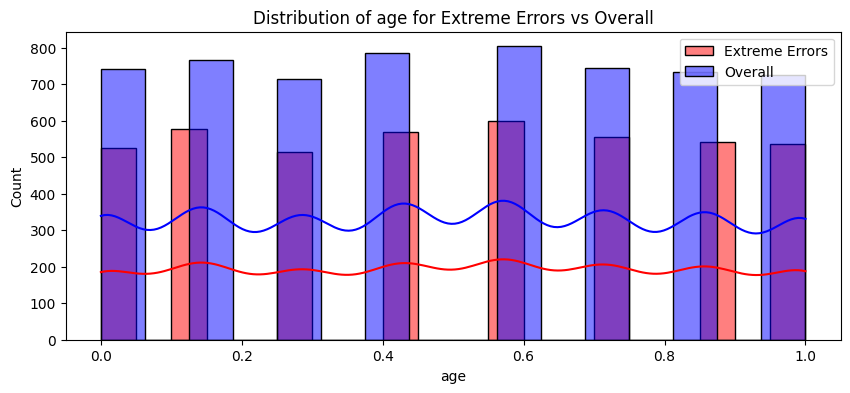

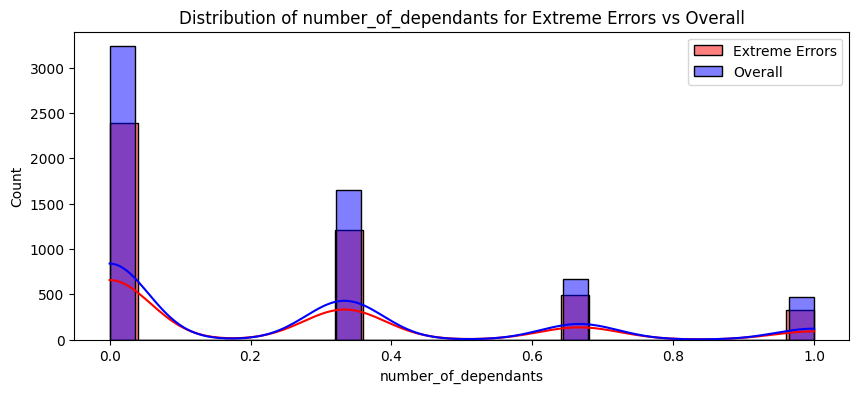

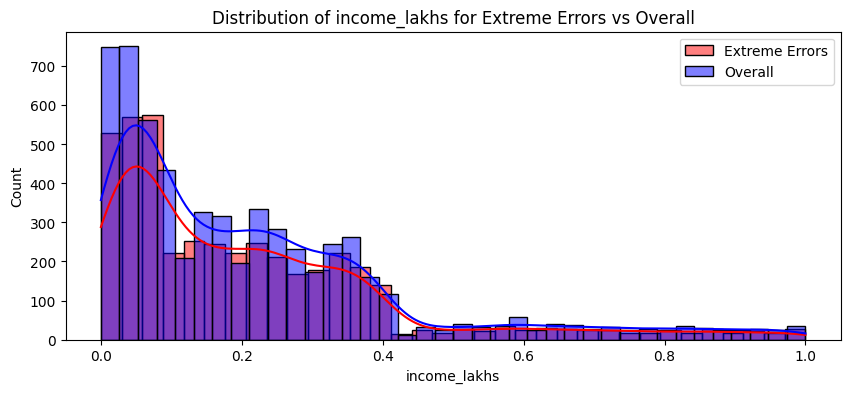

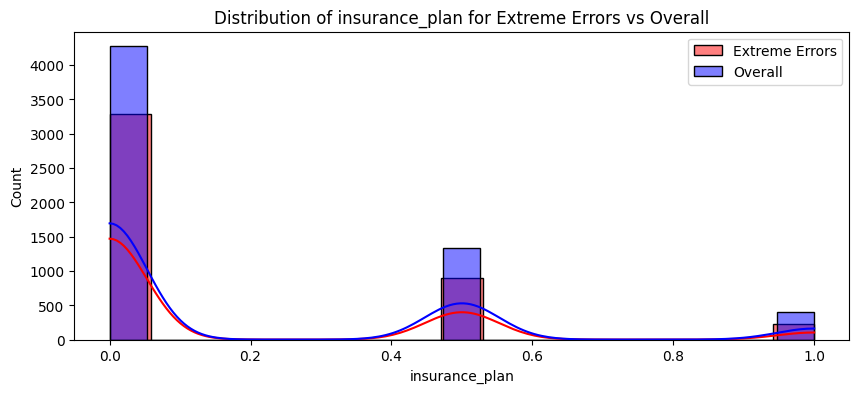

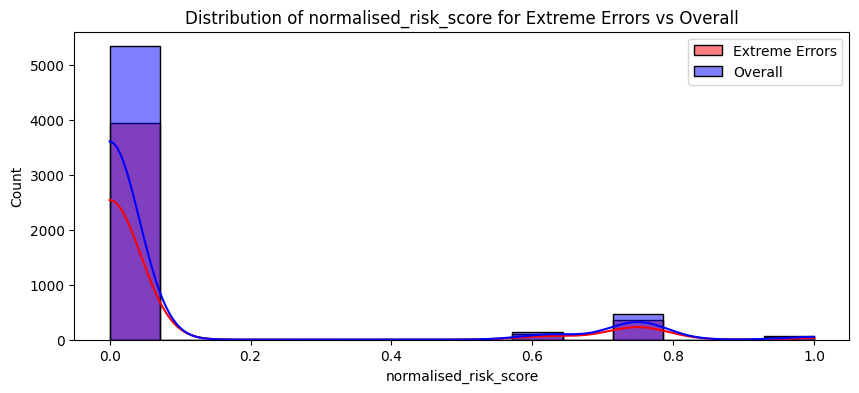

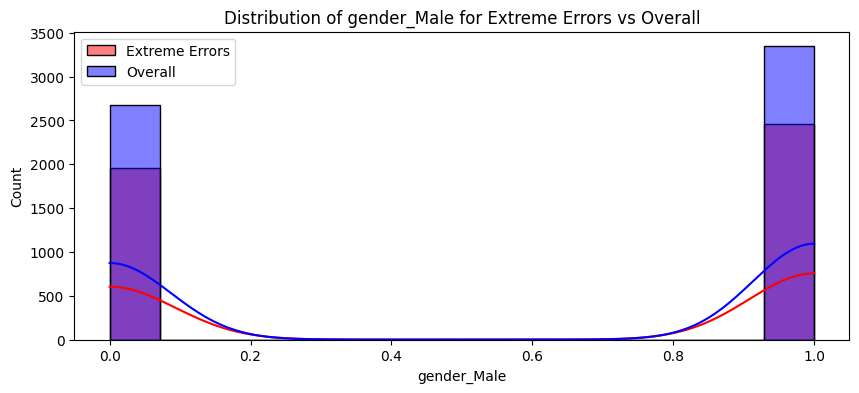

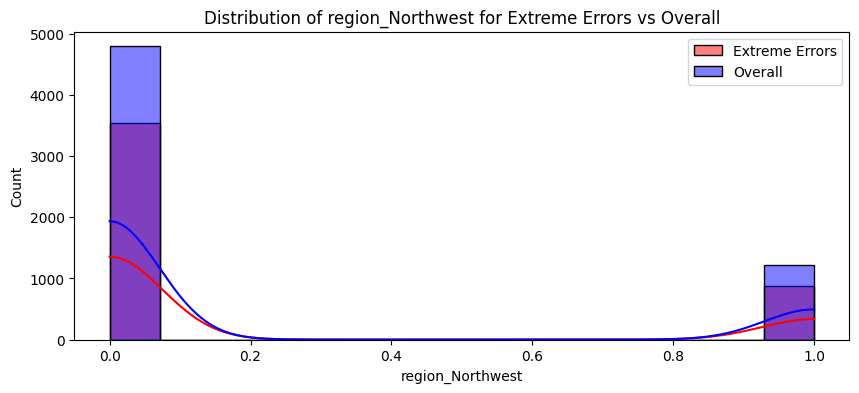

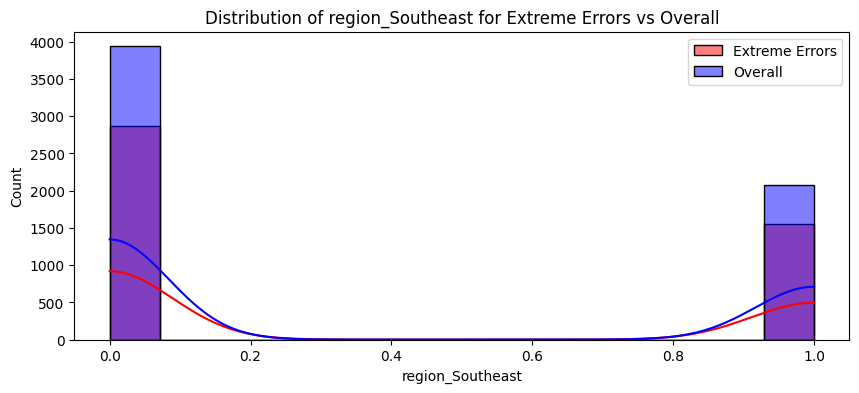

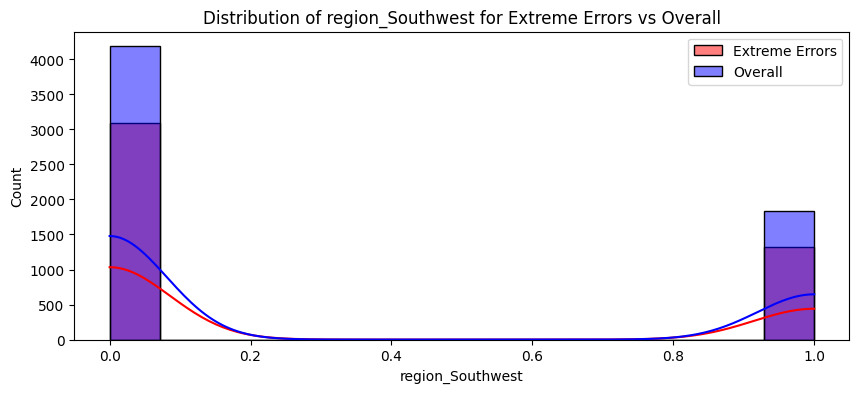

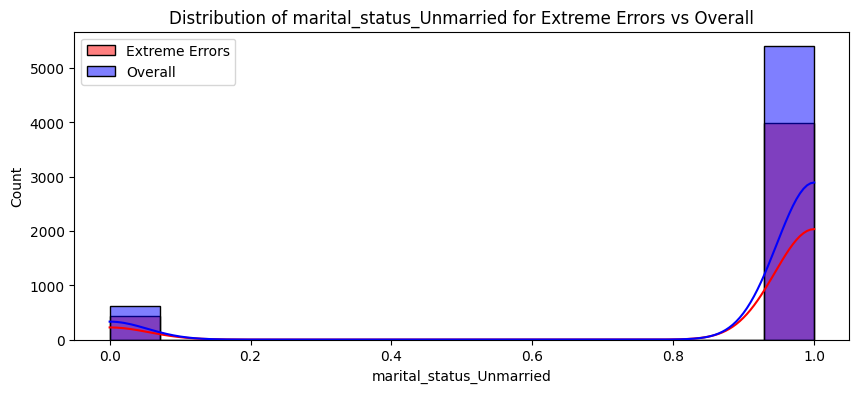

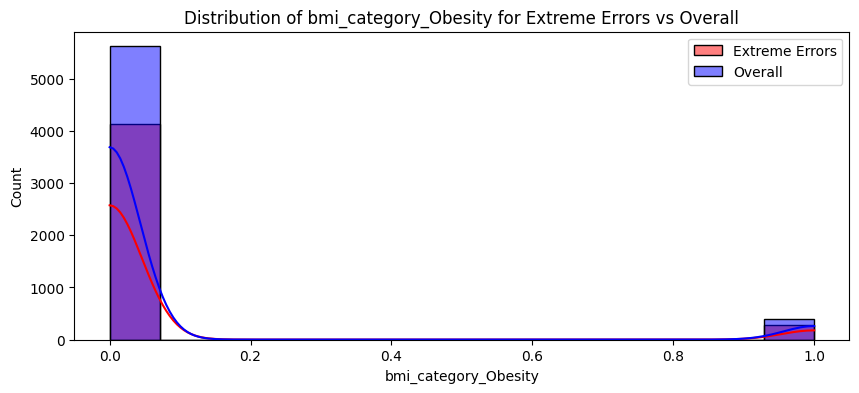

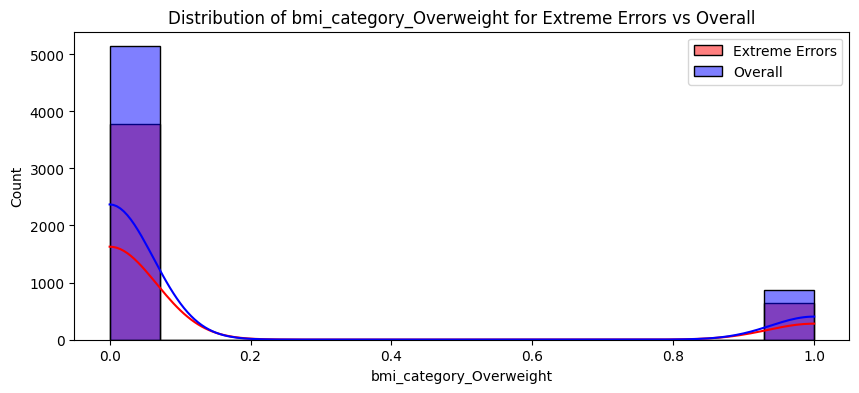

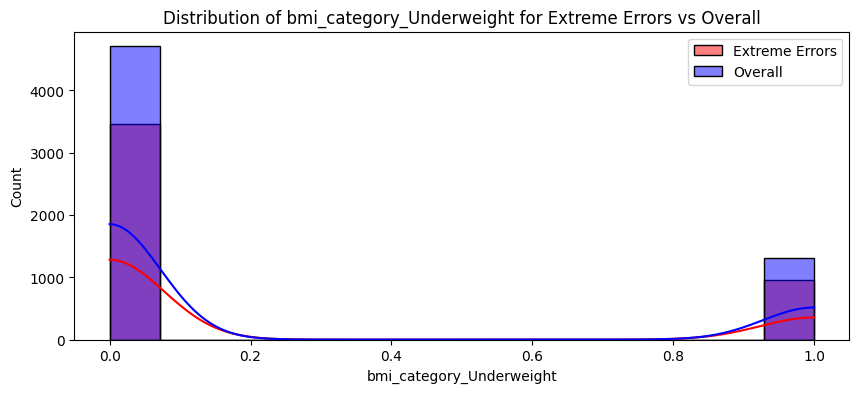

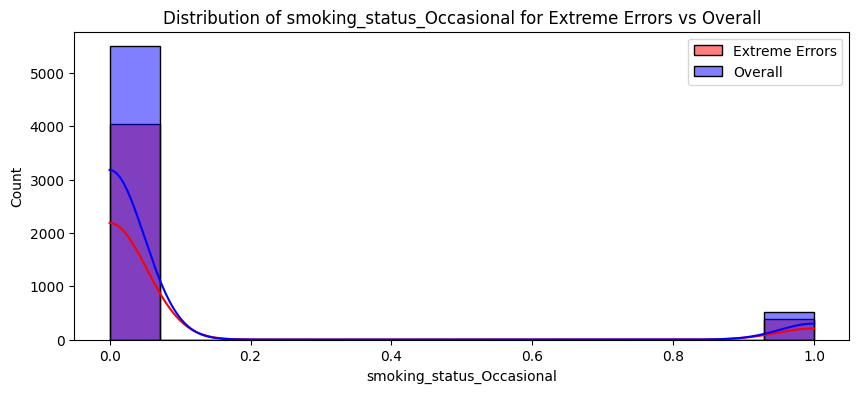

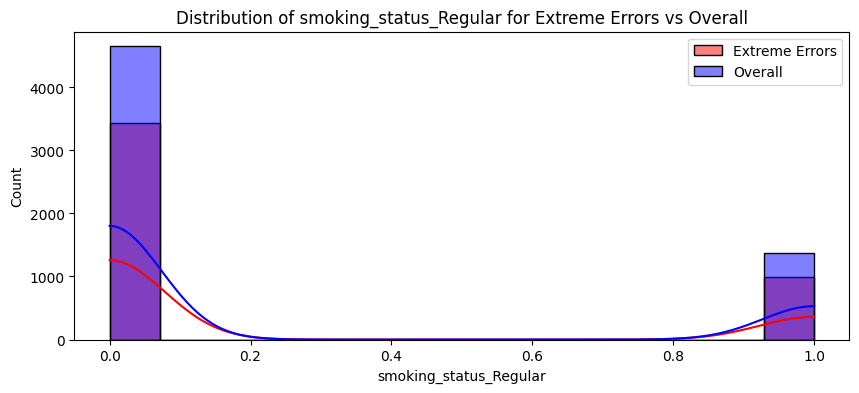

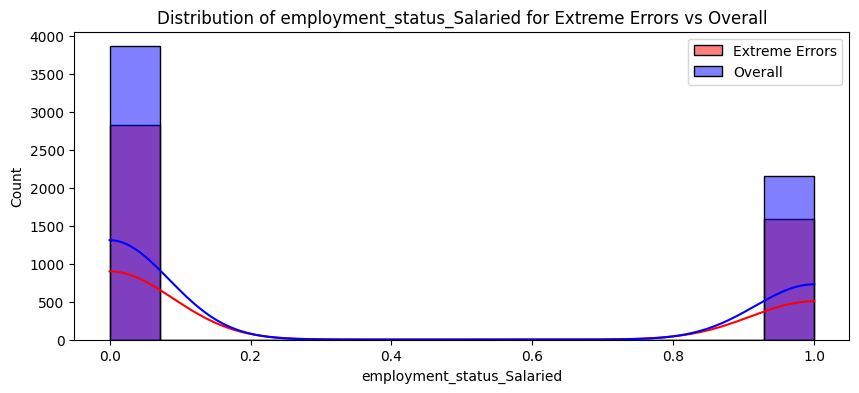

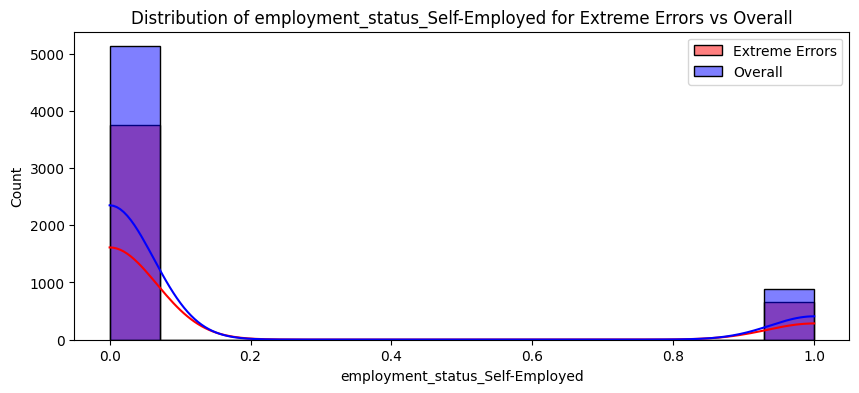

In [66]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

### Reverse Scaling

In [67]:
extreme_errors_df['income_level']=-1

In [68]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,0.0,-2.0,5.0,1.0
1,25.0,0.0,-2.0,6.0,1.0
2,21.0,0.0,-2.0,7.0,2.0
3,22.0,3.0,-2.0,27.0,2.0
4,18.0,0.0,-2.0,25.0,1.0


In [69]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4418.000000,4418.000000,4418.0,4418.000000,4418.000000
mean,21.505206,0.719556,-2.0,21.695337,1.306700
std,2.267107,0.934040,0.0,20.384652,0.563275
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,7.000000,1.000000
50%,22.000000,0.000000,-2.0,16.000000,1.000000
75%,23.000000,1.000000,-2.0,31.000000,2.000000
max,25.000000,3.000000,-2.0,99.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

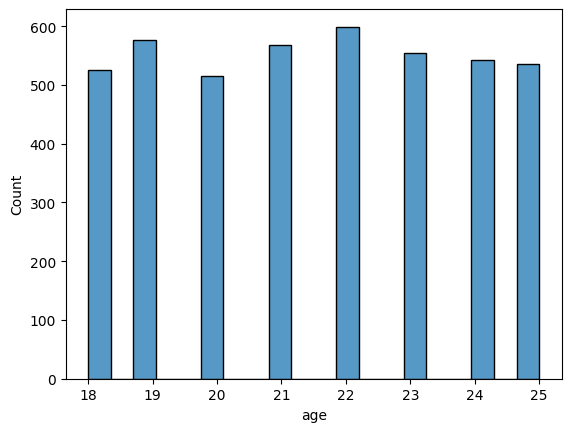

In [70]:
sns.histplot(df_reversed.age)

This shows that majority of the extreme errors are coming from young age group (i.e. <25 years of age). We need to may be build a separate model for this segment